In [141]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,RocCurveDisplay,PrecisionRecallDisplay,classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
import seaborn as sns


In [142]:
data = pd.read_csv("anemia.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      1421 non-null   int64  
 1   Hemoglobin  1421 non-null   float64
 2   MCH         1421 non-null   float64
 3   MCHC        1421 non-null   float64
 4   MCV         1421 non-null   float64
 5   Result      1421 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 66.7 KB


In [143]:
data.describe()

,Gender,Hemoglobin,MCH,MCHC,MCV,Result
count,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000
mean,0.520760,13.412738,22.905630,30.251232,85.523786,0.436312
std,0.499745,1.974546,3.969375,1.400898,9.636701,0.496102
min,0.000000,6.600000,16.000000,27.800000,69.400000,0.000000
25%,0.000000,11.700000,19.400000,29.000000,77.300000,0.000000
50%,1.000000,13.200000,22.700000,30.400000,85.300000,0.000000
75%,1.000000,15.000000,26.200000,31.400000,94.200000,1.000000
max,1.000000,16.900000,30.000000,32.500000,101.600000,1.000000


In [144]:
data.head()

,Gender,Hemoglobin,MCH,MCHC,MCV,Result
0,1,14.9,22.7,29.1,83.7,0
1,0,15.9,25.4,28.3,72.0,0
2,0,9.0,21.5,29.6,71.2,1
3,0,14.9,16.0,31.4,87.5,0
4,1,14.7,22.0,28.2,99.5,0


In [145]:
data.tail()

,Gender,Hemoglobin,MCH,MCHC,MCV,Result
1416,0,10.6,25.4,28.2,82.9,1
1417,1,12.1,28.3,30.4,86.9,1
1418,1,13.1,17.7,28.1,80.7,1
1419,0,14.3,16.2,29.5,95.2,0
1420,0,11.8,21.2,28.4,98.1,1


In [146]:
data = data.drop_duplicates()

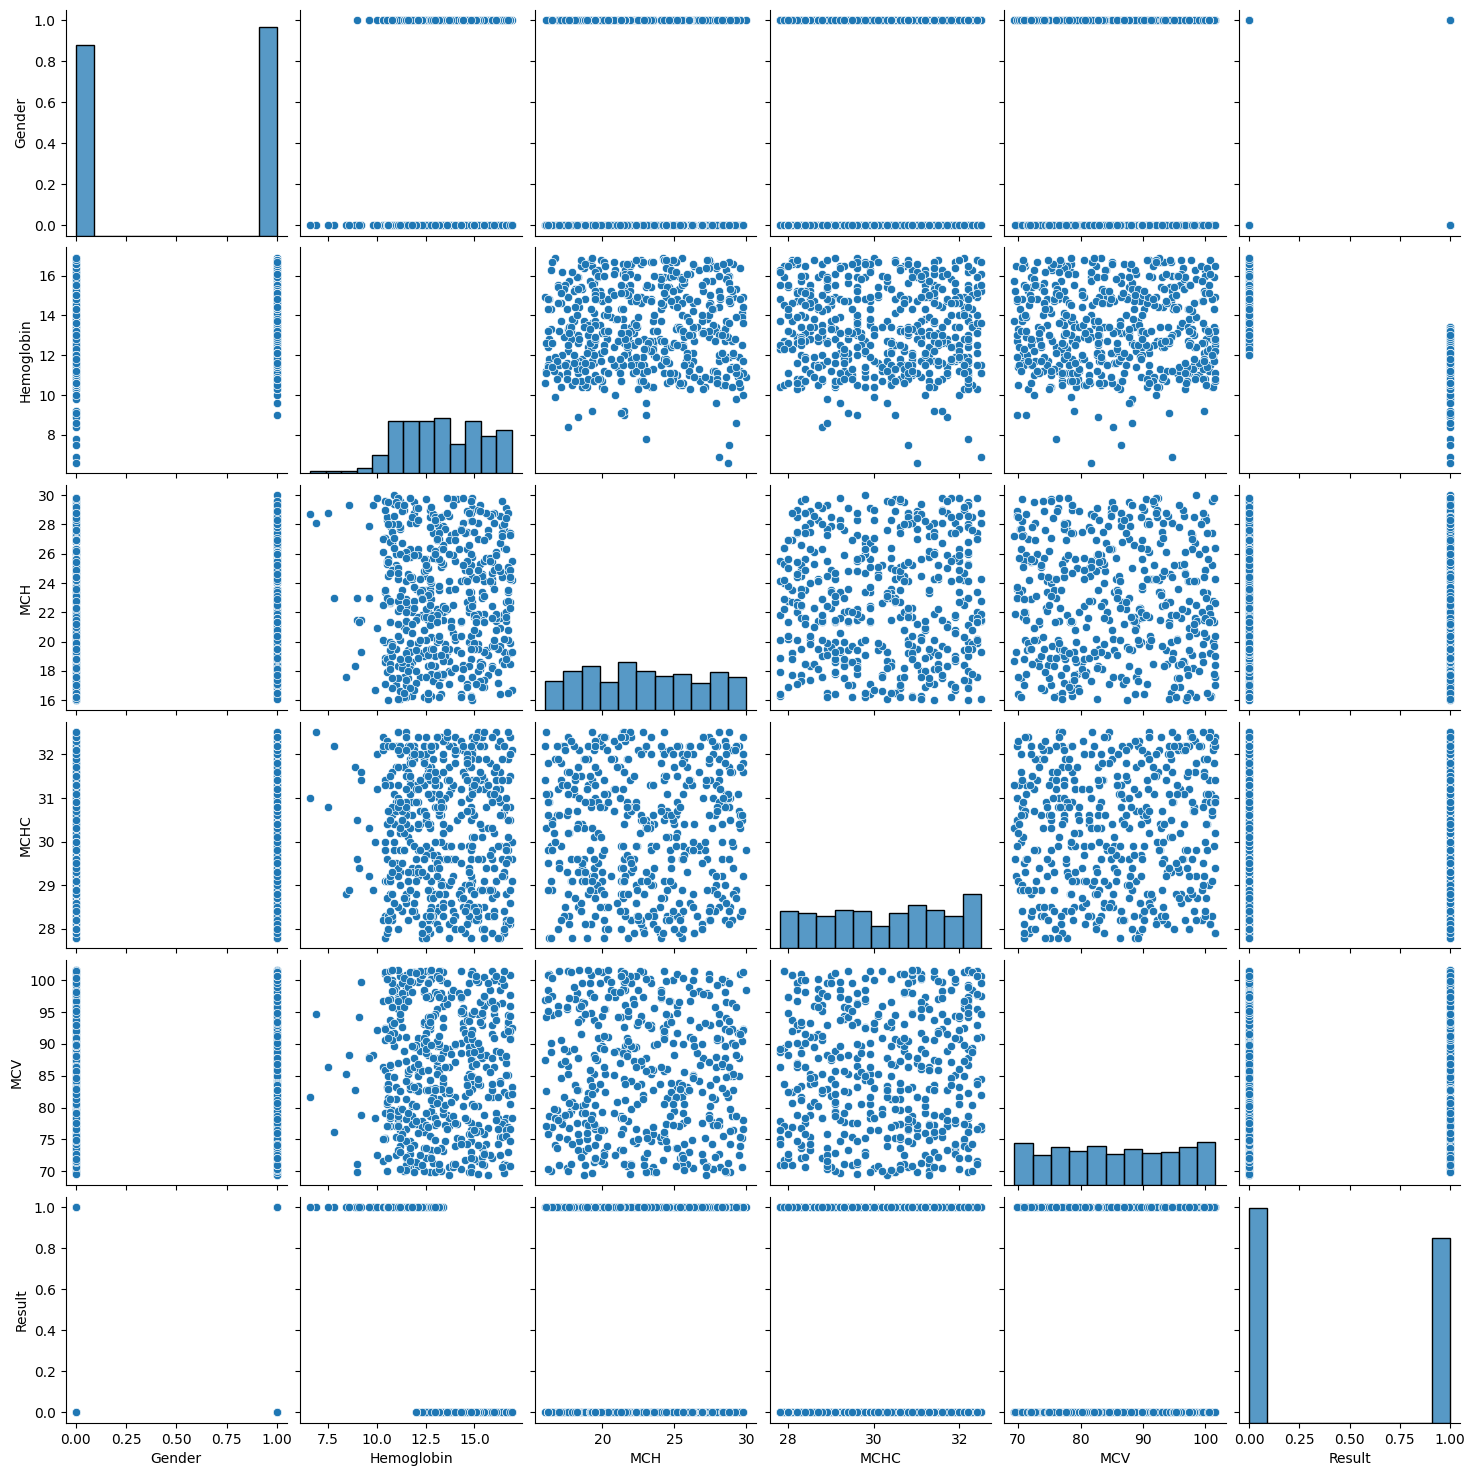

In [147]:
sns.pairplot(data)

array([[<Axes: title={'center': 'Gender'}>,
        <Axes: title={'center': 'Hemoglobin'}>],
       [<Axes: title={'center': 'MCH'}>,
        <Axes: title={'center': 'MCHC'}>],
       [<Axes: title={'center': 'MCV'}>,
        <Axes: title={'center': 'Result'}>]], dtype=object)

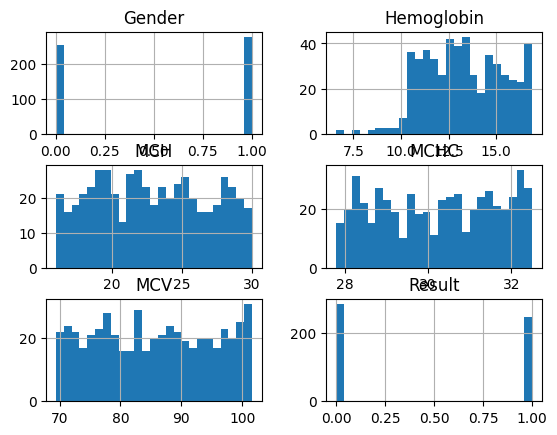

In [148]:
data.hist(bins=25)

<Axes: >

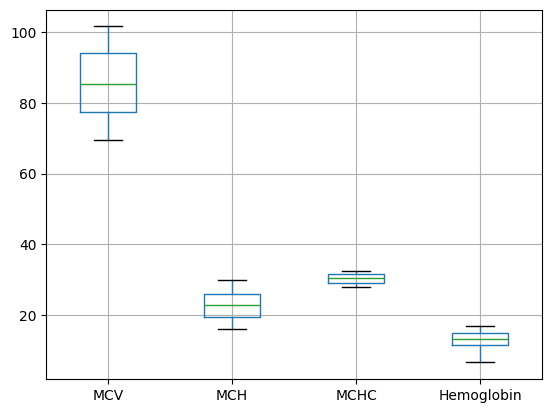

In [149]:
data.boxplot(["MCV","MCH","MCHC","Hemoglobin"])

In [150]:
class_distribution = data['Result'].value_counts(normalize=True)
print("Class Distribution:")
print(class_distribution)


Class Distribution:
Result
0    0.537453
1    0.462547
Name: proportion, dtype: float64


In [151]:
data["Gender"].value_counts()

Gender
1    279
0    255
Name: count, dtype: int64

In [152]:
data.isnull().sum()

Gender        0
Hemoglobin    0
MCH           0
MCHC          0
MCV           0
Result        0
dtype: int64

In [155]:
data.groupby(["Gender","Result"]).count()

Hemoglobin  MCH  MCHC  MCV
Gender Result                            
0      0              167  167   167  167
       1               88   88    88   88
1      0              120  120   120  120
       1              159  159   159  159

In [156]:
y = data["Result"]
x = data.drop(["Result","MCH","MCHC"],axis=1)
# x_dropped = data.drop(["MCH","MCHC"])

In [157]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [158]:
scaler = StandardScaler()
X_train = scaler.fit_transform(xtrain)
X_test = scaler.transform(xtest)

In [159]:
# Models to be evaluated
models = [
    ('RandomForest', RandomForestClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('SVM', SVC()),
    ("Logistic Regression",LogisticRegression(class_weight='balanced'))
]


In [160]:

# Pipeline for preprocessing and model training
results = {}
roc_auc_scores = {}
for name, model in models:
    pipe = Pipeline(steps=[('classifier', model)])
    # Define hyperparameters grid for GridSearchCV
    param_grid = {}
    if name == 'RandomForest':
        param_grid = {
            'classifier__n_estimators': [5,10,20,50, 100, 200],
            'classifier__max_depth': [None, 5, 10,20,30],
            'classifier__min_samples_split': [2, 5, 10],
            # 'classifier__class_weight': ['balanced']
        }
    elif name == 'GradientBoosting':
        param_grid = {
            'classifier__n_estimators': [5,10,20,50, 100, 200],
            'classifier__learning_rate': [0.1, 0.01,0.001],
            'classifier__max_depth': [3, 5, 7],
        }
    elif name == 'SVM':
        param_grid = {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            # 'classifier__class_weight': ['balanced']
        }
    
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(pipe, param_grid, cv=5)
    grid_search.fit(X_train, ytrain)
    
    # Save results
    results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'classification_report': classification_report(ytest, grid_search.predict(X_test))
    }


In [161]:

# Print results
for name, result in results.items():
    print(f"{name}:")
    print("  Best Parameters:", result['best_params'])
    print("  Best CV Score:", result['best_score'])
    print("classification_report", result["classification_report"])

RandomForest:
  Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 5}
  Best CV Score: 1.0
classification_report               precision    recall  f1-score   support

           0       1.00      0.98      0.99        58
           1       0.98      1.00      0.99        49

    accuracy                           0.99       107
   macro avg       0.99      0.99      0.99       107
weighted avg       0.99      0.99      0.99       107

GradientBoosting:
  Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 5}
  Best CV Score: 0.9976744186046511
classification_report               precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        49

    accuracy                           1.00       107
   macro avg       1.00      1.00      1.00       107
weighted avg       1.00      1.00    

In [177]:
rf = RandomForestClassifier(n_estimators=5,max_depth=3)
rf.fit(X_train,ytrain)
rf_y_preds = rf.predict(X_test)
print(accuracy_score(ytest,rf_y_preds))

0.9906542056074766


In [163]:
lr = LogisticRegression()
lr.fit(X_train,ytrain)
lr_y_preds = rf.predict(X_test)
print(accuracy_score(ytest,lr_y_preds))

1.0


In [179]:
svm = SVC(C= 10,kernel= 'linear')
svm.fit(X_train,ytrain)
svm_y_preds = rf.predict(X_test)
print(accuracy_score(ytest,svm_y_preds))

0.9906542056074766


In [178]:
gb = GradientBoostingClassifier(n_estimators=5)
gb.fit(X_train,ytrain)
gb_y_preds = rf.predict(X_test)
print(accuracy_score(ytest,gb_y_preds))

0.9906542056074766


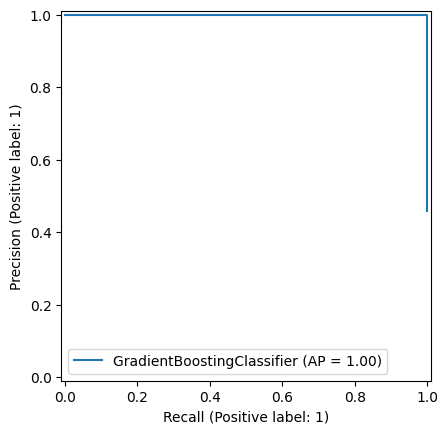

In [166]:
PrecisionRecallDisplay.from_estimator(gb,X_test,ytest)

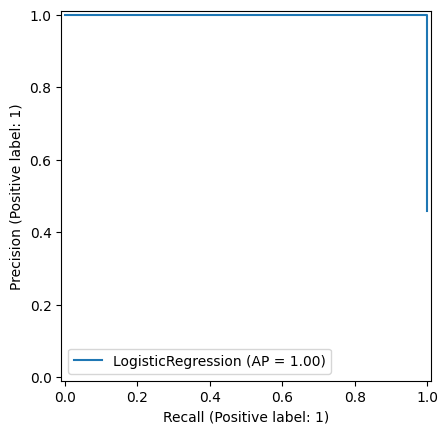

In [167]:
PrecisionRecallDisplay.from_estimator(lr,X_test,ytest)

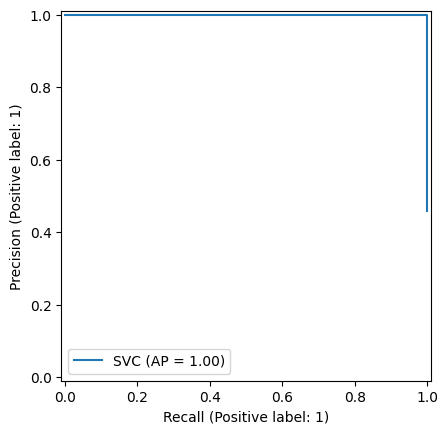

In [168]:
PrecisionRecallDisplay.from_estimator(svm,X_test,ytest)

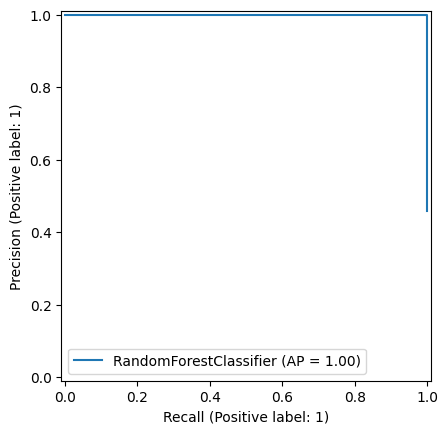

In [169]:
PrecisionRecallDisplay.from_estimator(rf,X_test,ytest)

/home/johanan/.local/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


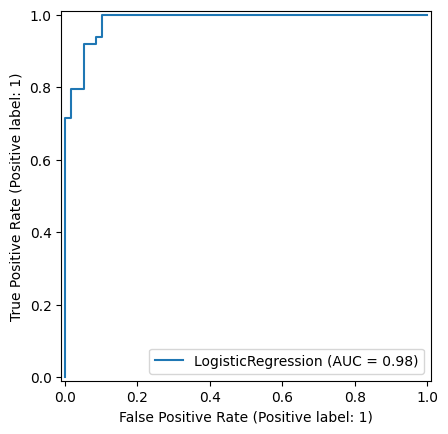

In [170]:
RocCurveDisplay.from_estimator(lr,xtest,ytest)

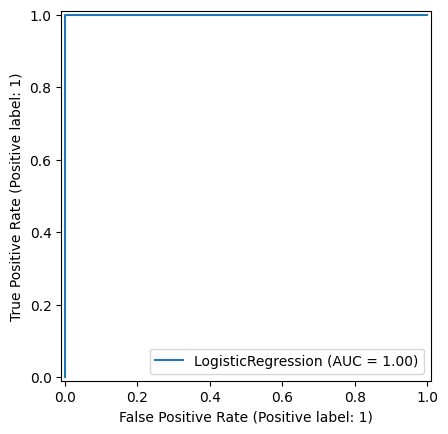

In [171]:
RocCurveDisplay.from_estimator(lr,X_test,ytest)

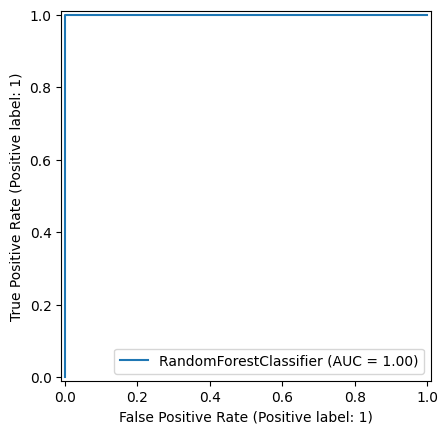

In [172]:
RocCurveDisplay.from_estimator(rf,X_test,ytest)

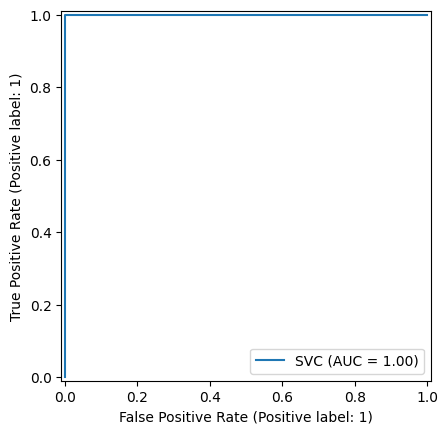

In [173]:
RocCurveDisplay.from_estimator(svm,X_test,ytest)

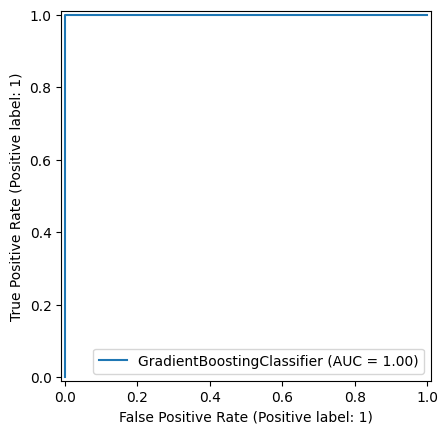

In [174]:
RocCurveDisplay.from_estimator(gb,X_test,ytest)

In [175]:
print(classification_report(ytest,lr_y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        49

    accuracy                           1.00       107
   macro avg       1.00      1.00      1.00       107
weighted avg       1.00      1.00      1.00       107



In [176]:
import joblib

joblib.dump(svm,"models/svm.pkl")
joblib.dump(lr,"models/logisticregression.pkl")
joblib.dump(gb,"models/gradientboostingclassifier.pkl")
joblib.dump(rf,"models/randomforest.pkl")

['models/randomforest.pkl']